In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CL', 'ES', 'GC', 'NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/blotter/trader_2020-02-24_11-15.csv')
del df['time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['sys_time'] = pd.to_datetime(df['sys_time'])
df.set_index('sys_time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
sys_time,,,,,,,,,
2020-02-24 13:04:27.876308,CL,BUY,1.0,51.39,906,stop-out,2.37,25.26,100025.26
2020-02-24 13:42:00.995696,CL,SELL,1.0,51.21,927,entry,2.37,0.00,100025.26
2020-02-24 14:02:47.843438,CL,BUY,1.0,51.39,928,stop-out,2.37,-184.74,99840.52
2020-02-24 14:34:30.765810,CL,SELL,1.0,51.17,929,entry,2.37,0.00,99840.52
2020-02-24 15:07:01.103266,ES,SELL,2.0,3238.75,931,entry,4.20,0.00,99840.52
...,...,...,...,...,...,...,...,...,...
2020-02-28 17:07:30.707400,CL,SELL,1.0,44.14,1138,entry,2.37,0.00,110928.22
2020-02-28 17:20:21.908122,ES,BUY,3.0,2906.25,1127,stop-out,6.30,-4587.60,106340.62
2020-02-28 17:20:37.953029,CL,BUY,1.0,44.16,1139,stop-out,2.37,-24.74,106315.88


In [4]:
df[df['contract'] == 'NQ']

,contract,action,amount,price,order_id,reason,commission,realizedPNL,cash
sys_time,,,,,,,,,
2020-02-24 15:30:34.365353,NQ,BUY,2.0,9064.500,934,stop-out,4.2,2731.6,102827.38
2020-02-25 16:25:00.782821,NQ,SELL,2.0,9068.500,727,entry,4.2,0.0,103013.54
2020-02-25 16:34:51.360962,NQ,BUY,2.0,9046.000,728,stop-out,4.2,891.6,103905.14
2020-02-25 16:52:00.631875,NQ,SELL,2.0,9022.500,731,entry,4.2,0.0,104110.40
2020-02-25 16:56:07.872695,NQ,BUY,2.0,9015.750,732,stop-out,4.2,261.6,104357.26
2020-02-25 17:06:00.771183,NQ,SELL,2.0,9005.000,737,entry,4.2,0.0,103802.74
2020-02-25 17:13:03.453304,NQ,BUY,2.0,9006.500,738,stop-out,4.2,-68.4,103734.34
2020-02-25 17:21:19.072673,NQ,BUY,2.0,8973.250,740,stop-out,4.2,191.6,102891.42
2020-02-25 19:18:30.707376,NQ,SELL,2.0,8940.250,747,entry,4.2,0.0,102521.94


In [5]:
df[(df['contract'] == 'NQ') & (df['realizedPNL'] == 0)].count()

contract       16
action         16
amount         16
price          16
order_id       16
reason         16
commission     16
realizedPNL    16
cash           16
dtype: int64

In [6]:
df.groupby('contract').realizedPNL.sum()

contract
CL      997.28
ES    -6417.60
GC    -1894.92
NQ    13526.60
Name: realizedPNL, dtype: float64

In [7]:
df.realizedPNL.sum()

6211.359999999999

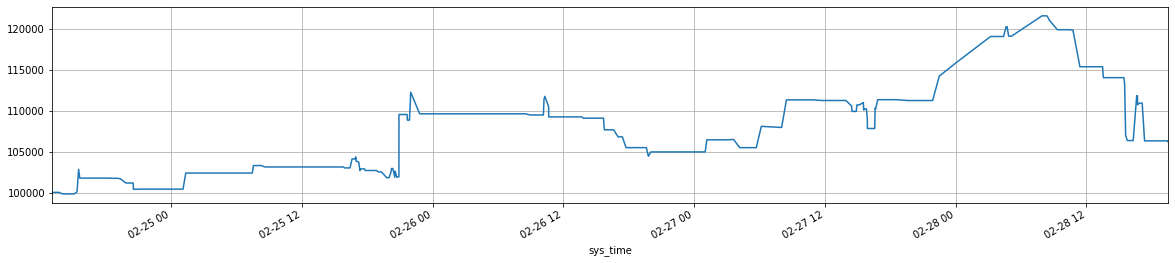

In [8]:
df.cash.plot(figsize=(20,4), grid=True);

In [9]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [10]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL    55
ES    23
GC    46
NQ    42
Name: action, dtype: int64

In [11]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    130.35
ES    111.30
GC    333.96
NQ    176.40
Name: commission, dtype: float64

In [12]:
df.commission.sum()

752.01

In [13]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
CL,0.39,35.62,265.26,-112.98,2.35,34.53,28.0
NQ,0.58,520.25,1516.93,-838.85,1.81,527.50,26.0
ES,0.33,-534.80,3816.60,-2710.50,1.41,-556.56,12.0
GC,0.24,-90.23,2355.48,-854.52,2.76,-84.12,21.0
total,0.40,71.39,1506.16,-894.31,1.68,65.88,87.0


In [14]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CLZ9', 'ESZ9', 'GCZ9', 'NQZ9']].plot(figsize=(20,8), grid=True);

In [15]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CL,ES,GC,NQ,total
contract,,,,,
CL,1.000000,0.434454,-0.960268,0.194700,0.133724
ES,0.434454,1.000000,-0.253107,0.109792,0.879902
GC,-0.960268,-0.253107,1.000000,-0.389155,-0.043970
NQ,0.194700,0.109792,-0.389155,1.000000,0.430820
total,0.133724,0.879902,-0.043970,0.430820,1.000000


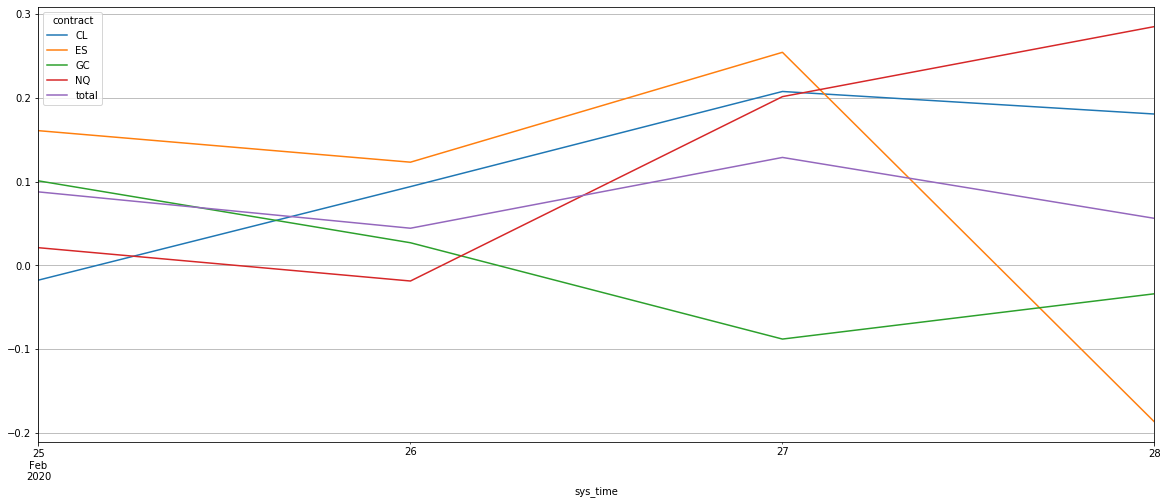

In [16]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

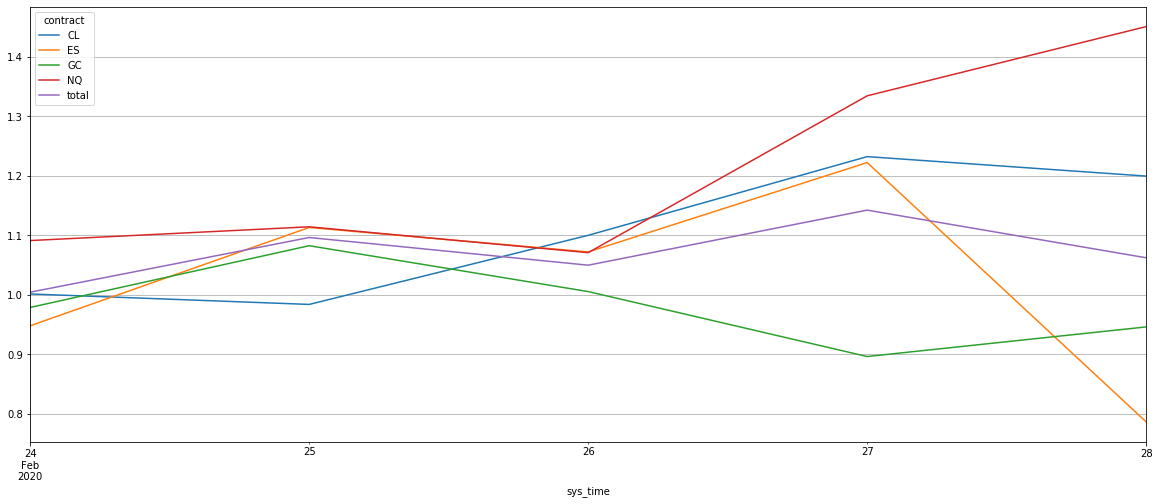

In [17]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [18]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,9566.749377,-0.999995,-0.939513,1.400644e+08,19.845719
Cumulative returns,0.199456,-0.213920,-0.054141,4.508867e-01,0.062114
Annual volatility,1.171778,3.349017,1.405618,1.691811e+00,1.174324
Sharpe ratio,8.411364,-1.977916,-1.421719,1.211890e+01,3.064753
Calmar ratio,360052.239319,-2.802397,-5.457579,3.591434e+09,282.943671
Stability,0.824772,0.067857,0.333495,7.524937e-01,0.252448
Max drawdown,-0.026570,-0.356835,-0.172148,-3.899958e-02,-0.070140
Omega ratio,5.431230,0.705314,0.803017,1.143097e+01,1.634154
Sortino ratio,43.590312,-2.573791,-2.137839,7.405253e+01,6.182858
Skew,0.353691,-0.697798,0.185076,5.832085e-01,0.055609


In [19]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,CL,ES,GC,NQ,total
sys_time,,,,,
2020-02-29,19.79,-17.06,-3.35,32.98,5.76


In [20]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
CL       20.0
ES      -17.0
GC       -3.0
NQ       33.0
total     6.0
dtype: float64

In [21]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
sys_time,,,,
2020-02-25 20:54:47.113115,ES,BUY,3144.25,7591.60
2020-02-28 16:37:20.645095,GC,BUY,1591.10,5475.48
2020-02-25 21:59:10.931629,GC,BUY,1631.20,3405.48
2020-02-27 08:28:19.019869,ES,BUY,3092.25,3366.60
2020-02-28 03:12:31.452132,ES,BUY,2976.00,3166.60
...,...,...,...,...
2020-02-26 15:45:48.074234,GC,BUY,1631.50,-1424.52
2020-02-25 22:48:45.448849,ES,BUY,3144.25,-2633.40
2020-02-28 11:24:35.035522,ES,BUY,2928.00,-4475.10
